In [2]:
import numpy as np
import pandas as pd
import pickle
import re
from collections import defaultdict
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding,Dense,Input,Flatten
from keras.layers import Conv1D,MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')

Using TensorFlow backend.


In [4]:
df = pd.read_csv("cleaned_Data.csv")

In [5]:
df.head()

,Tweets,Classification,word_count,char_count,avg_word,stopwords,hastags
0,extends china tariff deadline cites progress t...,False,12,104,7.750000,1,0
1,fras99 cancelled thegoodgodabove help,False,12,78,5.583333,6,0
2,benito mussolini atlantic excellent piece,False,11,84,7.200000,2,0
3,us delay china tariff increase,False,9,65,6.333333,1,0
4,potus realdonaldtrump also quoted mussolini re...,False,23,189,7.260870,3,0


In [6]:
df=df.drop(columns=['word_count', 'char_count','avg_word','stopwords','hastags'],axis=1)

In [7]:
df

,Tweets,Classification
0,extends china tariff deadline cites progress t...,False
1,fras99 cancelled thegoodgodabove help,False
2,benito mussolini atlantic excellent piece,False
3,us delay china tariff increase,False
4,potus realdonaldtrump also quoted mussolini re...,False
...,...,...
5218,young black girl bronx couple years back neon ...,True
5219,bff dont mess one time,False
5220,yeah got small loan shes famous sister leaked ...,True
5221,im lip challenge,False


In [8]:
df['Classification'].unique()

array([False,  True])

In [9]:
Class = []
for cat in df['Classification']:
    if cat == False:
        cls = Class.append(0)
    else:
        cls = Class.append(1)
df['Classification'] = Class

df.head()

,Tweets,Classification
0,extends china tariff deadline cites progress t...,0
1,fras99 cancelled thegoodgodabove help,0
2,benito mussolini atlantic excellent piece,0
3,us delay china tariff increase,0
4,potus realdonaldtrump also quoted mussolini re...,0


In [10]:
df

,Tweets,Classification
0,extends china tariff deadline cites progress t...,0
1,fras99 cancelled thegoodgodabove help,0
2,benito mussolini atlantic excellent piece,0
3,us delay china tariff increase,0
4,potus realdonaldtrump also quoted mussolini re...,0
...,...,...
5218,young black girl bronx couple years back neon ...,1
5219,bff dont mess one time,0
5220,yeah got small loan shes famous sister leaked ...,1
5221,im lip challenge,0


In [11]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.3

In [12]:
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Classification'])))

Shape of dataset  (5223, 2)
Index(['Tweets', 'Classification'], dtype='object')
No. of unique classes 2


In [13]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [14]:
df = df.astype(str)

In [15]:
macronum = sorted(set(df['Classification']))

In [16]:
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [17]:
def fun(i):
    return macro_to_id[i]

In [18]:
df['Classification'] = df['Classification'].apply(fun)

In [19]:
texts = []
labels = []

In [20]:
for idx in range(df.Tweets.shape[0]):
    text = BeautifulSoup(df.Tweets[idx])
    texts.append(clean_str(str(text.get_text().encode())))

In [21]:
for idx in df['Classification']:
    labels.append(idx)

In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [24]:
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 7466


In [25]:
data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)

In [27]:
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (5223, 1000)
Shape of Label Tensor: (5223, 2)


In [28]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [29]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [31]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [32]:
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [33]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [35]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Simplified convolutional neural network
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         746700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_____________

In [36]:
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [37]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=128,callbacks=[cp])
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 3657 samples, validate on 1566 samples
Epoch 1/10
3657/3657 [==============================] - 34s 9ms/step - loss: 0.4547 - acc: 0.8285 - val_loss: 0.3548 - val_acc: 0.8653

Epoch 00001: val_acc improved from -inf to 0.86526, saving model to model_cnn.hdf5
Epoch 2/10
3657/3657 [==============================] - 16s 4ms/step - loss: 0.3683 - acc: 0.8633 - val_loss: 0.4413 - val_acc: 0.8665

Epoch 00002: val_acc improved from 0.86526 to 0.86654, saving model to model_cnn.hdf5
Epoch 3/10
3657/3657 [==============================] - 16s 4ms/step - loss: 0.3372 - acc: 0.8693 - val_loss: 0.3192 - val_acc: 0.8774

Epoch 00003: val_acc improved from 0.86654 to 0.87739, saving model to model_cnn.hdf5
Epoch 4/10
3657/3657 [==============================] - 16s 4ms/step - loss: 0.3026 - acc: 0.8745 - val_loss: 0.3258 - val_acc: 0.8838

Epoch 00004: val_acc improved from 0.87739 to 0.88378, saving model to model_cnn.hdf5
Epoch 5/10
3657/365

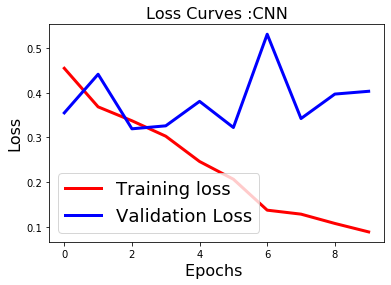

In [38]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

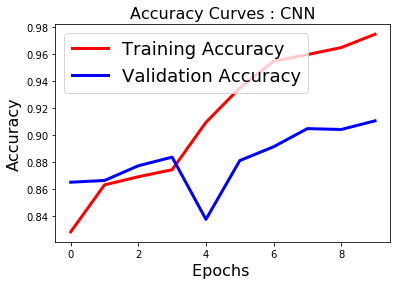

In [39]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [44]:
model.save("Cyber.h5")

In [47]:
from keras.models import load_model
m = load_model("Cyber.h5")

In [53]:
m